In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input

# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import datetime
import time
import re
from tqdm import tqdm

%matplotlib inline

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['dog-breed-identification', 'testni', 'output', 'vgg16', 'vgg16-weights-tf']


Čitanje training skupa

In [2]:
# path to training dataset
train_path = '../input/dog-breed-identification/train'
data_dir = '../input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
#labels = pd.read_csv('labels.csv')

model_dir = '../input/'
list_images = [train_path+f for f in os.listdir(train_path) if re.search('jpg|JPG', f)]

print(list_images[0:4])
train_labels = os.listdir(train_path)

['../input/dog-breed-identification/train8fd5567056096a09aad51d3518b95b49.jpg', '../input/dog-breed-identification/train9bd01fec0fe84bf86b25219968808abc.jpg', '../input/dog-breed-identification/traind2181ad8aa2f5fe3f6ef63b0bae7cc52.jpg', '../input/dog-breed-identification/train890727594626c0fa7092624bb9261387.jpg']


In [3]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Broj primjera u training skupu i broj oznaka/pasmina

In [4]:
n = len(labels)
breed = set(labels['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
n_class = len(breed)
print(n)
print(n_class)

10222
120


Broj pasa koji pripadaju određenemoj pasmini(rangirano)

In [5]:
yy = pd.value_counts(labels['breed'])
print(yy[0:16])

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
airedale                107
tibetan_terrier         107
cairn                   106
leonberg                106
japanese_spaniel        105
beagle                  105
Name: breed, dtype: int64


Distribucija pasmina

Text(0.5, 1.0, 'Distribution of the Dog Breeds')

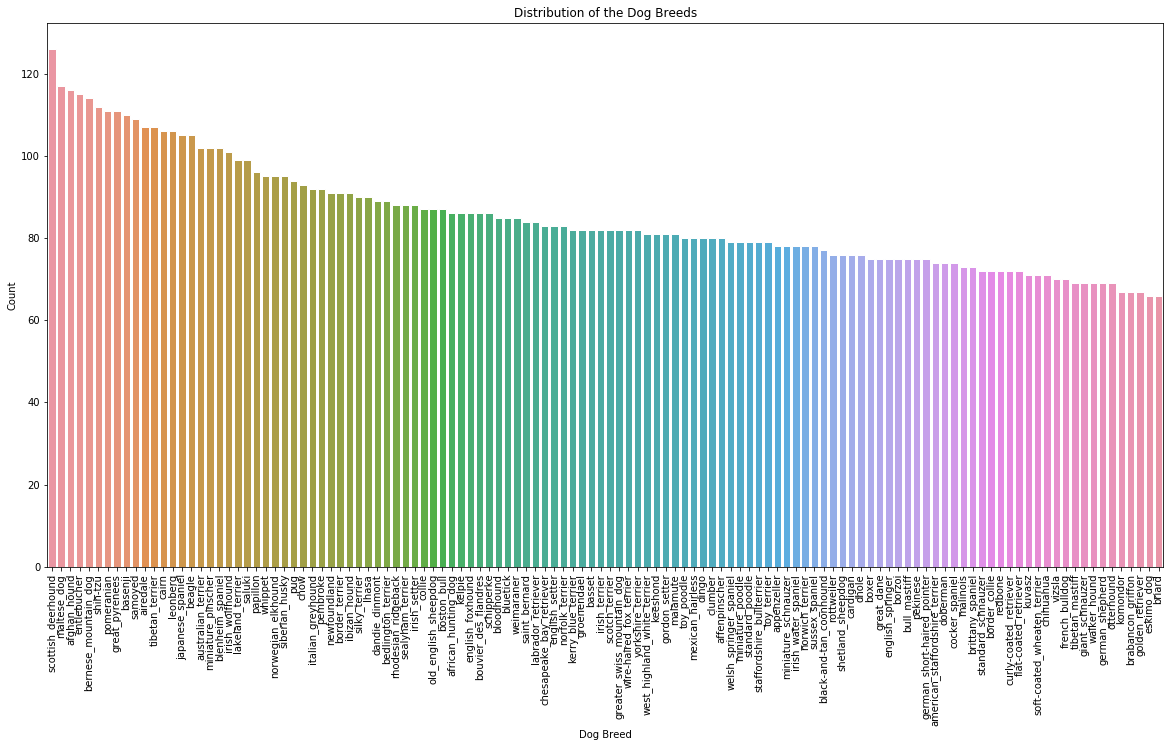

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of the Dog Breeds')

Promjena oznaka u one_hot kodirane

In [7]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

Postavljanje dimenzija slika

In [8]:
import cv2
width = 224
orig_label = []
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
orig_label = []
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('../input/dog-breed-identification/train/%s.jpg' % labels['id'][i]), (width, width))
    y[i] = one_hot_labels[i]
    orig_label.append(labels['breed'][i])

100%|██████████| 10222/10222 [00:54<00:00, 187.55it/s]


In [9]:
print(orig_label[0:5])

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever']


Broj primjera (slika) i oznaka (pasmina)

In [10]:
print("Number of Samples:",X.shape[0])
print(y.shape)
num_class = y.shape[1]
print("Number of training lables:",num_class)

Number of Samples: 10222
(10222, 120)
Number of training lables: 120


Neke od slika iz training skupa

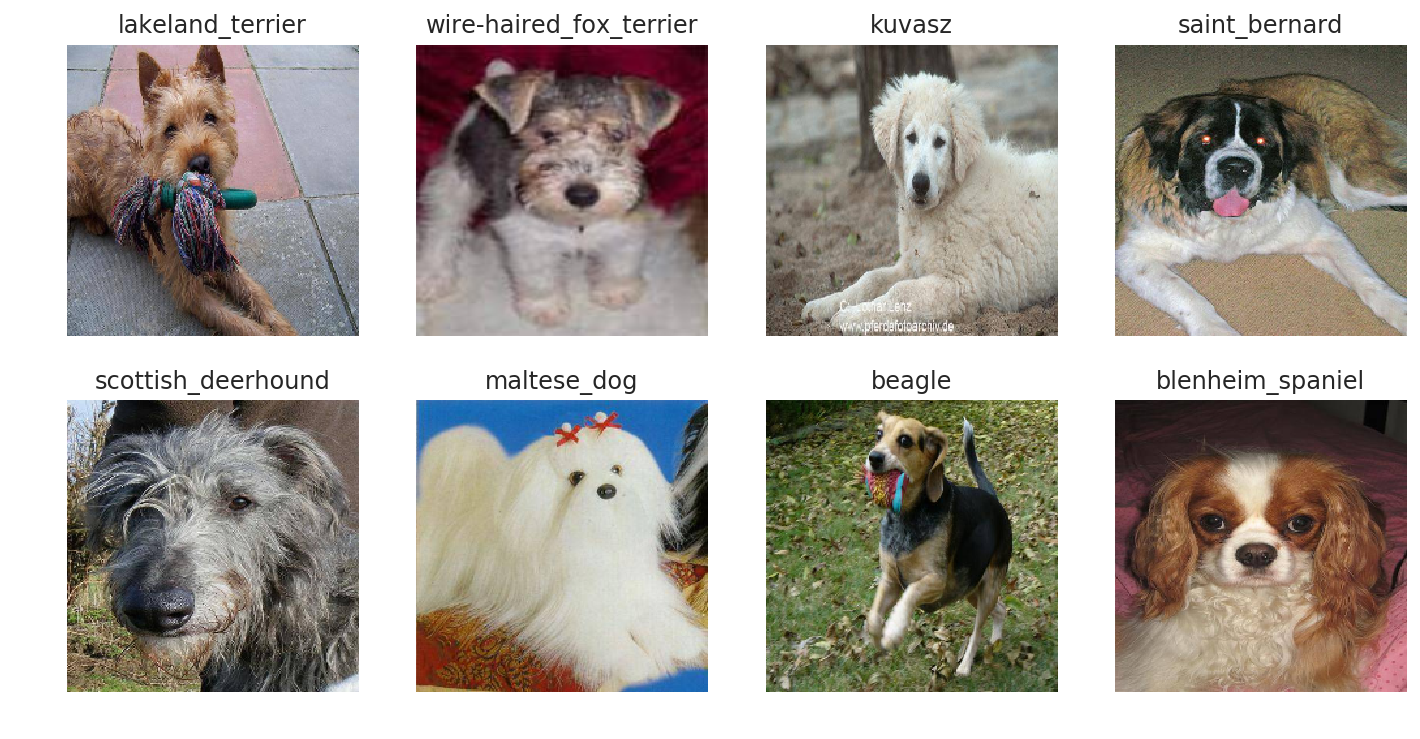

In [11]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(orig_label[random_index])
    plt.axis('off')

Čitanje test podataka


In [12]:
df_test = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

Promjena dimezija test skupa

In [13]:
n_test = len(df_test)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('../input/dog-breed-identification/test/%s.jpg' % df_test['id'][i]), (width, width))

100%|██████████| 10357/10357 [01:00<00:00, 172.03it/s]


In [14]:
print(len(X_test))

10357


Ekstrakcija značajki pomoću VGG-a

In [15]:
#from keras import applications
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *

def get_features(MODEL, data=X):
    cnn_model = MODEL(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False, input_shape=(width, width, 3))
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [16]:
vgg16_features = get_features(VGG16, X)

Instructions for updating:
Colocations handled automatically by placer.
10222/10222 [==============================] - 28s 3ms/step


In [17]:
inputs = Input(vgg16_features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(vgg16_features, y, batch_size=128, epochs=10, validation_split=0.1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 9199 samples, validate on 1023 samples
Epoch 1/10
9199/9199 [==============================] - 1s 82us/step - loss: 14.5085 - acc: 0.0201 - val_loss: 11.8142 - val_acc: 0.0635
Epoch 2/10
9199/9199 [==============================] - 0s 32us/step - loss: 13.0113 - acc: 0.0561 - val_loss: 9.2825 - val_acc: 0.1593
Epoch 3/10
9199/9199 [==============================] - 0s 30us/step - loss: 11.1663 - acc: 0.1056 - val_loss: 7.3607 - val_acc: 0.2669
Epoch 4/10
9199/9199 [==============================] - 0s 30us/step - loss: 9.6837 - acc: 0.1721 - val_loss: 6.2151 - val_acc: 0.3294
Epoch 5/10
9199/9199 [==============================] - 0s 31us/step - loss: 8.3357 - acc: 0.2249 - val_loss: 5.2875 - val_acc: 0.3851
Epoch 6/10
9199/9199 [==============================] - 0s 29us/step - loss: 7.3588 - acc: 0.2749 - val_loss: 

In [18]:
vgg16_feature_test = get_features(VGG16, X_test)

10357/10357 [==============================] - 29s 3ms/step


In [19]:
y_pred = model.predict(vgg16_feature_test, batch_size=128)

In [20]:
for b in breed:
    df_test[b] = y_pred[:,class_to_num[b]]

In [21]:
df_test.to_csv('submission.csv', index=None)

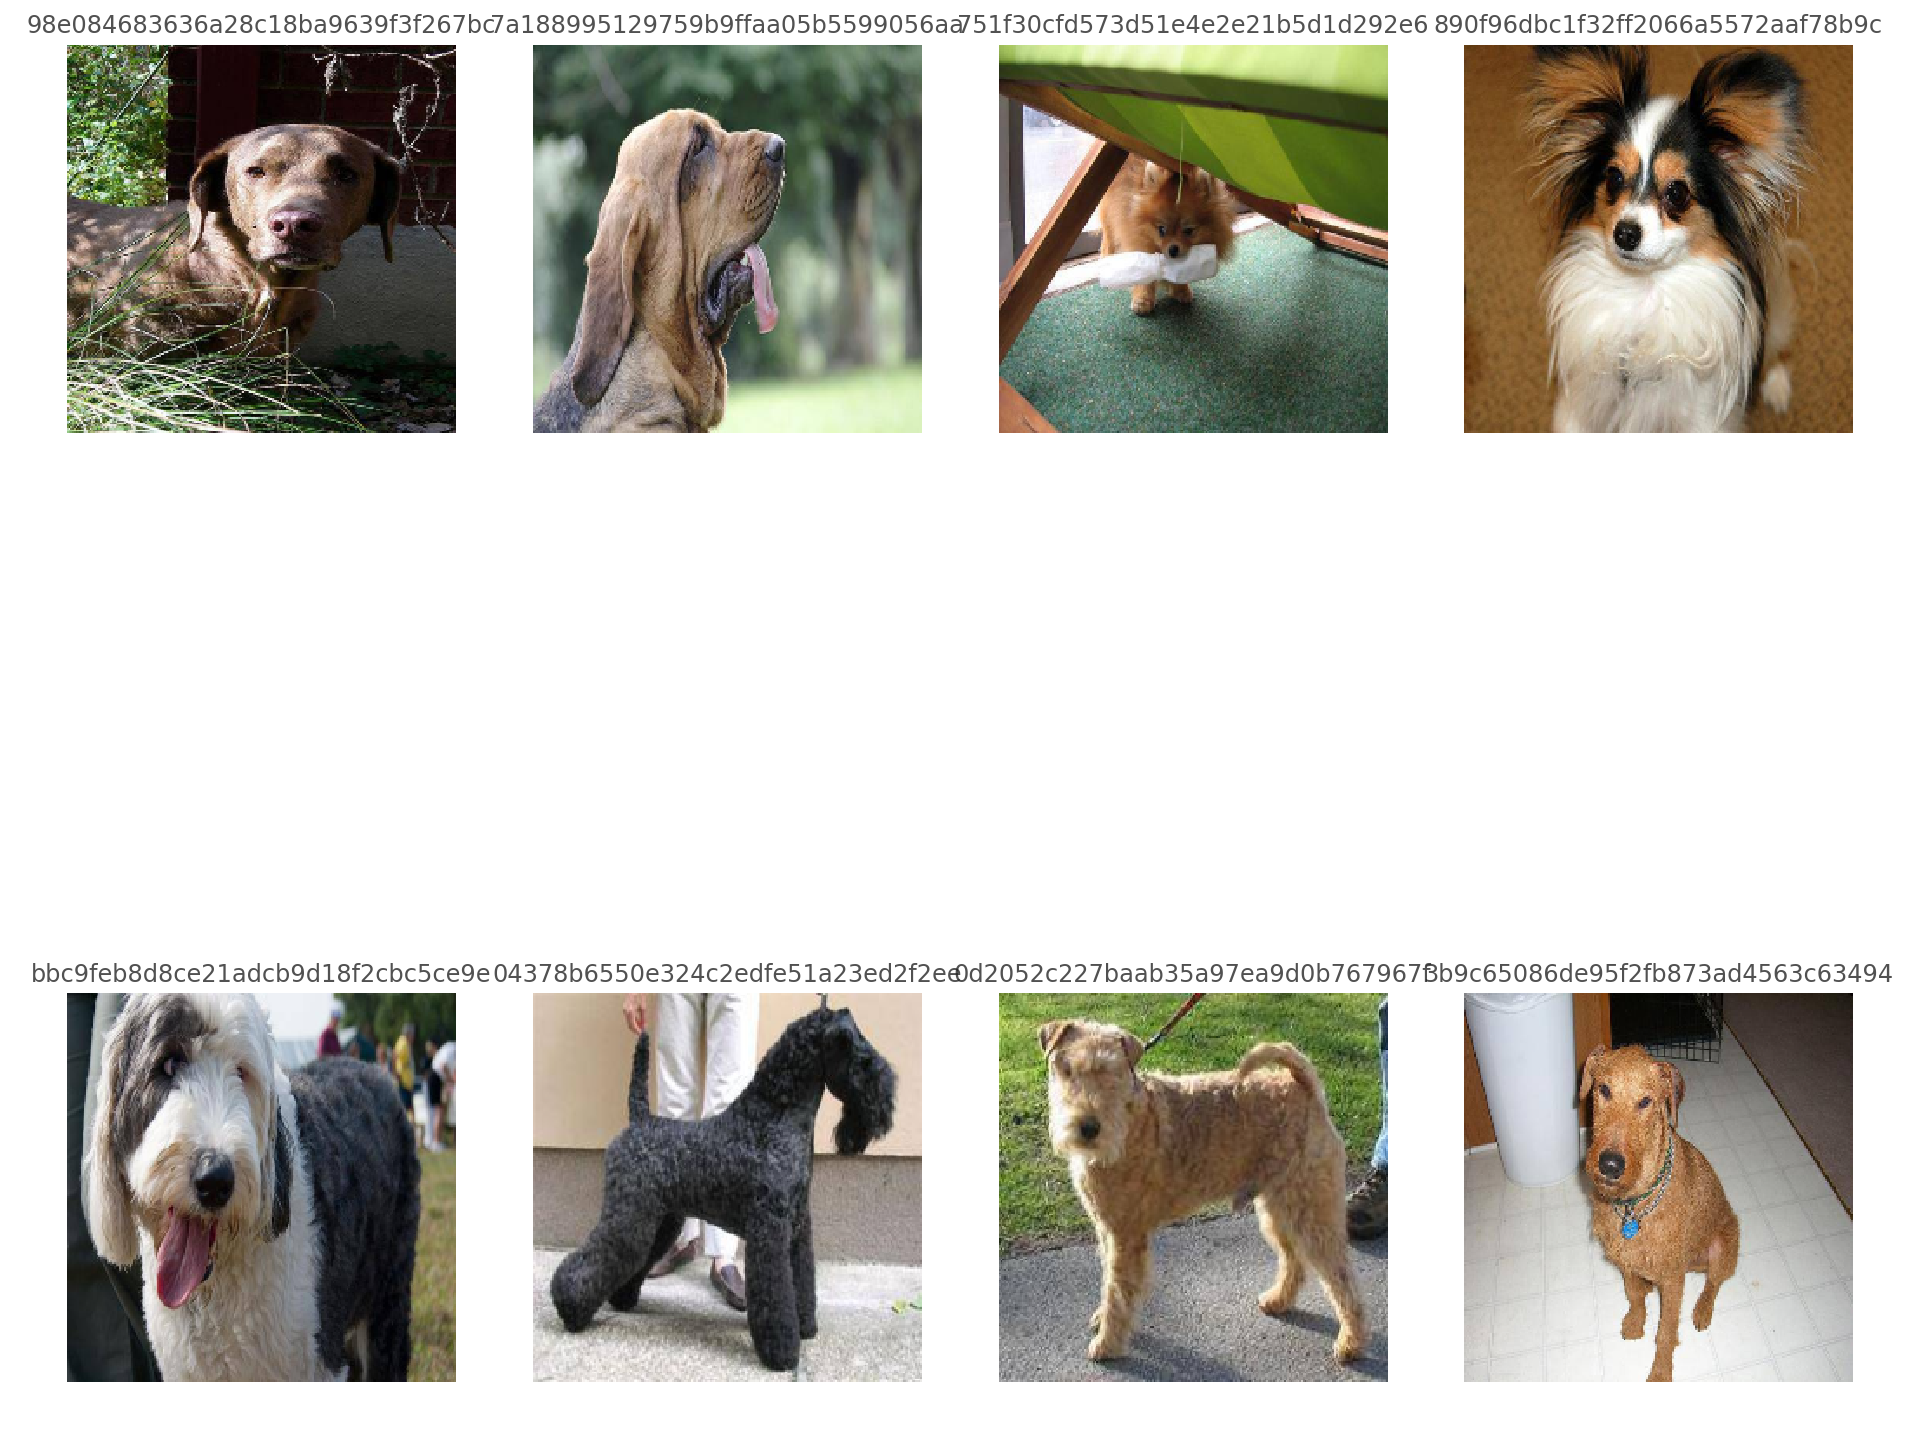

In [24]:
import random
import matplotlib.pyplot as plt


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(1, figsize=(16, 16))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[random_index][:,:,::-1])
    plt.title(df_test['id'][random_index], alpha=0.8)
    plt.axis('off')